In [23]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v7
from Resources.Game import *


### Initializing shared game stats
##### Only once st the start

In [69]:
# stats = torch.Tensor([0, 0, 0, 0]) # batch index, white wins, black wins, draws
# torch.save(stats, '/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/stats')

##### Initialize Model

In [74]:
model = Model_v7()
model_saves = os.listdir('../Monte Carlo/Model Saves MC v7 Parallel')
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v7 Parallel/model_{}_batches'.format(newest_model)))
# model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v7 Parallel/model_800_batches'))
criterion = nn.MSELoss()

# error_hist =  []
# latest_batch_index = 0


error_hist = torch.load('./error_hist MC v7')

batches:  tensor(1960, dtype=torch.int32)
batches:  tensor(1970, dtype=torch.int32)
batches:  tensor(1980, dtype=torch.int32)
batches:  tensor(1990, dtype=torch.int32)
batches:  tensor(2000, dtype=torch.int32)


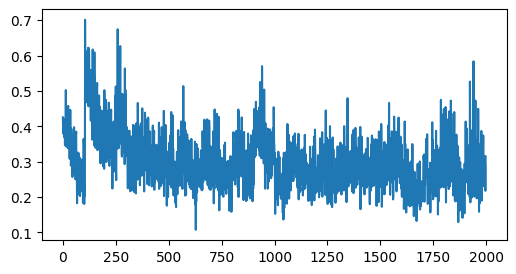

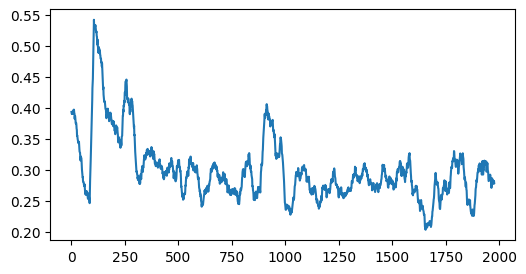

batches:  tensor(2010, dtype=torch.int32)
batches:  tensor(2020, dtype=torch.int32)
batches:  tensor(2030, dtype=torch.int32)
batches:  tensor(2040, dtype=torch.int32)
batches:  tensor(2050, dtype=torch.int32)


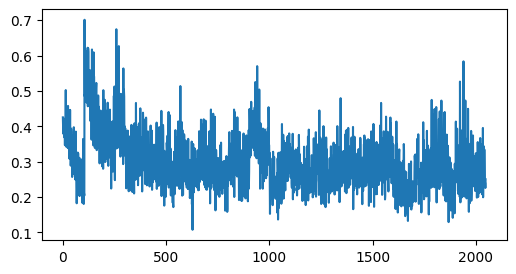

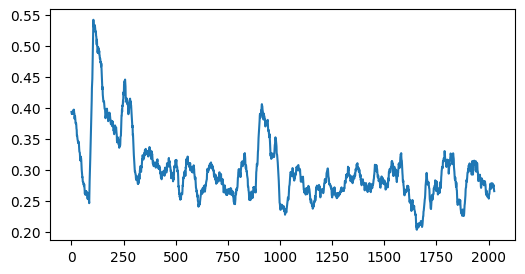

batches:  tensor(2060, dtype=torch.int32)
batches:  tensor(2070, dtype=torch.int32)
batches:  tensor(2080, dtype=torch.int32)
batches:  tensor(2090, dtype=torch.int32)
batches:  tensor(2100, dtype=torch.int32)


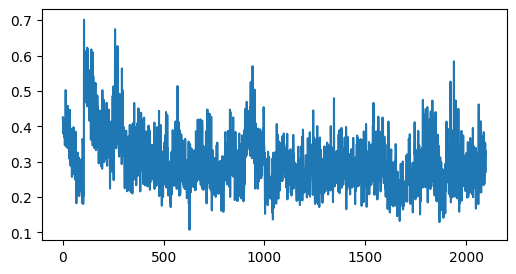

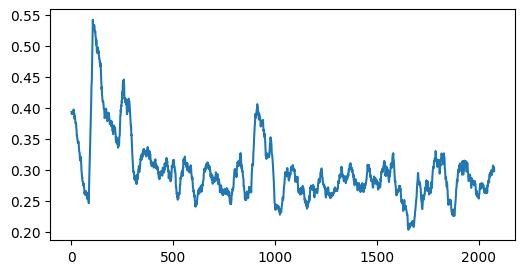

batches:  tensor(2110, dtype=torch.int32)
batches:  tensor(2120, dtype=torch.int32)
batches:  tensor(2130, dtype=torch.int32)
batches:  tensor(2140, dtype=torch.int32)
batches:  tensor(2150, dtype=torch.int32)


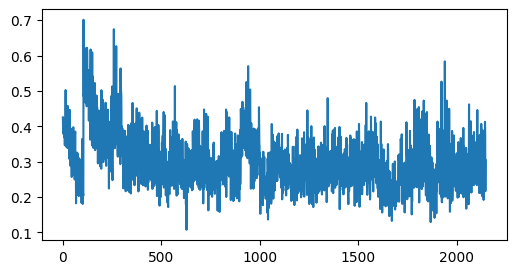

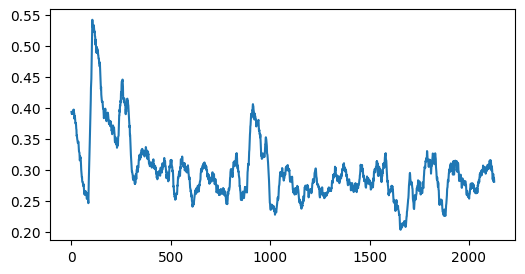

batches:  tensor(2160, dtype=torch.int32)
batches:  tensor(2170, dtype=torch.int32)
batches:  tensor(2180, dtype=torch.int32)
batches:  tensor(2190, dtype=torch.int32)
batches:  tensor(2200, dtype=torch.int32)


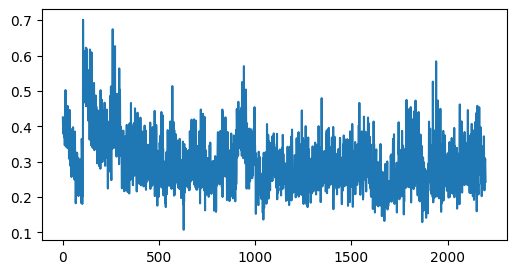

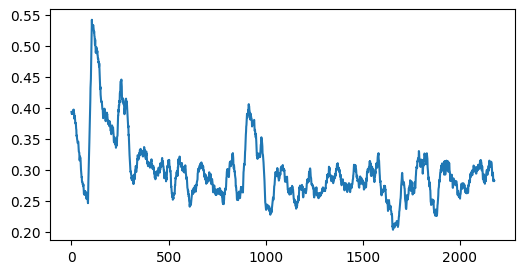

batches:  tensor(2210, dtype=torch.int32)
batches:  tensor(2220, dtype=torch.int32)
batches:  tensor(2230, dtype=torch.int32)
batches:  tensor(2240, dtype=torch.int32)
batches:  tensor(2250, dtype=torch.int32)


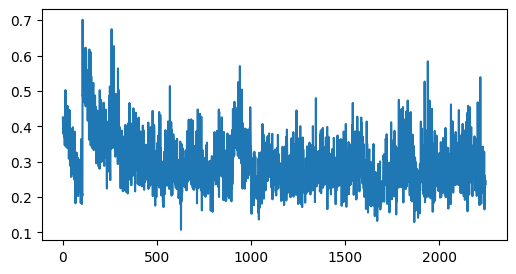

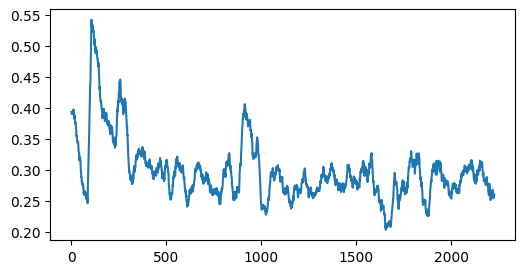

batches:  tensor(2260, dtype=torch.int32)
batches:  tensor(2270, dtype=torch.int32)


KeyboardInterrupt: 

In [75]:
learning_rate = 5e-5
weight_decay = 1e-2     # L2 regularization to avoid overfitting
n_minibatch = 100       # number of minibatches per training batch

while True:

    # wait for new data
    while True:
        try:
            with open('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/stats', 'rb') as f:
                stats = torch.load(f)
        except:
            time.sleep(0.05)
            continue
        if stats[0] - 1 > latest_batch_index:
            newest_batch = stats[0] - 1
            break
        else:
            time.sleep(0.05)

    # load all new data
    inputs = []
    labels = []
    for index in range(latest_batch_index + 1, newest_batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = 3
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v7/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # print('training batch ', newest_batch)
    t0 = time.time()

    # training step
    model.train()
    # learning_rate = 5e-4 * 500 / (500 + game_count) # reducing learning rate, 1/n one possible options
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    if newest_batch % 10 == 0 and newest_batch > 0:

        print('batches: ', newest_batch)
    
    torch.save(error_hist, './error_hist MC v7')

    if newest_batch % 50 == 0 and newest_batch > 0:


        plt.figure(figsize=(6, 3))
        plt.plot(error_hist, label='(training) error hist')
        plt.show()

        plt.figure(figsize=(6, 3))
        plt.plot([np.mean(error_hist[i:(i+20)]) for i in range(len(error_hist) - 20)], label='(training) error hist, rolling mean (20)')
        plt.show()

        torch.save(model.state_dict(), './Model Saves MC v7 Parallel/model_{}_batches'.format(newest_batch))

    latest_batch_index = newest_batch